In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pandas.errors import EmptyDataError

path = "/media/plankton/30781fe1-cea5-4503-ae00-1986beb935d2/Segmentation_results/M181/results_240328/M181-175-1_CTD-050_00°00S-019°00W_20220509-0543/Data"

In [8]:
files = [os.path.join(path, file) for file in os.listdir(path) if file.endswith(".csv")]

In [8]:
VOLUME_PER_IMAGE = 50 * (3.5)**2 * np.pi  # in cubic centimeters
VOLUME_PER_IMAGE_LITERS = VOLUME_PER_IMAGE / 1000  # convert to liters
# esd_bins = np.array([
#                 100.0, 126.0, 158.0, 200.0, 251.0, 316.0, 398.0, 501.0, 631.0, 794.0, 1000.0,
#                 1259.0, 1585.0, 1995.0, 2512.0, 3162.0, 3981.0, 5012.0, 6310.0, 7943.0, 10000.0,
#                 12589.0, 15849.0, 19953.0, 25119.0, 31623.0, 39811.0, 50119.0, 63096.0, 79433.0,
#                 100000.0, 125893.0, 158489.0, 199526.0, 251189.0, 316228.0, 398107.0, 501187.0,
#                 630957.0, 794328.0, 1000000.0, 1258925.0, 1584893.0, 1995262.0, 2511886.0,
#                 3162278.0, 3981072.0, 5011872.0, 6309573.0, 7943282.0, 10000000.0
#             ])
esd_bins = np.array([0,125,250,500,1000,100000])

depth_bins = 5 #meters

def area_to_esd(area: float) -> float:
    pixel_size = 13.5*2 #in µm/pixel @ 2560x2560 
    return 2 * np.sqrt(area * pixel_size**2 / np.pi)



In [32]:
from sqlalchemy import create_engine

# Create a connection to the PostgreSQL database
# *Verify Installation: Verify that PostgreSQL has been successfully installed and is running by checking its status:

# sudo systemctl status postgresql
# Log in to the PostgreSQL Database: By default, PostgreSQL creates a user named postgres with the role of the database superuser. Switch to the postgres user and then access the PostgreSQL prompt:

# sudo -i -u postgres
# psql
# You should now be at the PostgreSQL prompt, indicated by postgres=#.

# *Create a New PostgreSQL Database and User: From the PostgreSQL prompt, you can create a new database and user for your application:

# CREATE DATABASE pisco_crops_db;
# CREATE USER plankton WITH ENCRYPTED PASSWORD 'piscodisco';

# *Grant Privileges: After creating your new database and user, you'll need to give the user access to the database:

# GRANT ALL PRIVILEGES ON DATABASE your_database_name TO your_username;
# Exit PostgreSQL: To exit the PostgreSQL prompt, type \q and then press ENTER. To return to your regular system user from the postgres user, type exit or press CTRL+D.

# *Configure Remote Access (Optional): If you need to access your PostgreSQL database from a remote machine, you'll need to configure your pg_hba.conf and postgresql.conf files. By default, PostgreSQL is configured to allow connections only from the local machine.

# *Grant permissions to create table to user plankton
# log into pisco_crops_db: 
# psql -d pisco_crops_db -W
#  
# pisco_crops_db=> GRANT ALL ON SCHEMA public TO plankton;
# GRANT


# Setup connection parameters
username = 'plankton'
password = 'piscodisco'
host = 'localhost'  # or the IP address of your database server
port = '5432'       # default port for PostgreSQL
database = 'pisco_crops_db'

# Create an engine that connects to the PostgreSQL server
engine = create_engine(f'postgresql://{username}:{password}@{host}:{port}/{database}')

In [11]:
def gen_crop_df(path:str, small:bool):
    
    def area_to_esd(area: float) -> float:
        pixel_size = 13.5*2 #in µm/pixel @ 2560x2560 
        return 2 * np.sqrt(area * pixel_size**2 / np.pi)

    # Function to concatenate directory and filename
    def join_strings(directory, filename):
        return os.path.join(directory, filename)

    directory = os.path.dirname(path)
    directory = os.path.join(directory,'Crops')

    files = [os.path.join(path, file) for file in sorted(os.listdir(path)) if file.endswith(".csv")]
    dataframes = []
    empty_file_counter = 0
    id = 1
    for file in files:
        if 'settings' in file:
            continue
        #print(file)
        try:
            df = pd.read_csv(file, delimiter=",", header=None)
            df.insert(0,'',id)
            dataframes.append(df)
            id+=1
        except EmptyDataError:
            empty_file_counter += 1
            print(f"File {file} is empty")
    df = pd.concat(dataframes, ignore_index=True)
    headers = ["img_id","index", "filename", "area", "x", "y", "w", "h", "saved"]
    df.columns = headers
    df.reset_index(drop=True, inplace=True)
    df.drop("index", axis=1, inplace=True)

    if not small:
        df = df[df["saved"] == 1]
    #df.drop("saved", axis=1, inplace=True)

    # Split the 'filename' column
    split_df = df['filename'].str.split('_', expand=True)
    headers = ["date-time", "pressure", "temperature", "index"]
    split_df.columns = headers
    #split_df.drop("x", axis=1, inplace=True)
    split_df['pressure'] = split_df['pressure'].str.replace('bar', '').astype(float)
    split_df['temperature'] = split_df['temperature'].str.replace('C', '').astype(float)
    split_df['index'] = split_df['index'].str.replace('.png', '').astype(int)

    # Concatenate the new columns with the original DataFrame
    df = pd.concat([split_df, df], axis=1)

    # Extend the original 'filename' column
    df['full_path'] = df.apply(lambda x: join_strings(directory, x['filename']), axis=1)
    #df = df.drop('filename', axis=1)

    df['esd'] = df['area'].apply(area_to_esd).round(2)
    df['pressure'] = (df['pressure']-1)*10
    df.rename(columns={'pressure': 'pressure [dbar]'}, inplace=True)

    # Sort the DataFrame by the 'date-time' column
    df = df.sort_values(by=['date-time','index'], ascending=True)
    df.reset_index(drop=True, inplace=True)

    return df

In [12]:
crop_df = gen_crop_df(path, False)
crop_df.head()

/tmp/ipykernel_341390/1633812161.py:46: FutureWarning: The default value of regex will change from True to False in a future version.
  split_df['index'] = split_df['index'].str.replace('.png', '').astype(int)


,date-time,pressure [dbar],temperature,index,img_id,filename,area,x,y,w,h,saved,full_path,esd
0,20220509-05473797,-0.03,30.26,4,1,20220509-05473797_000.997bar_30.26C_4.png,707.5,1545.5,2455.5,71.0,43.0,1,/media/plankton/30781fe1-cea5-4503-ae00-1986be...,810.37
1,20220509-05473797,-0.03,30.26,34,1,20220509-05473797_000.997bar_30.26C_34.png,504.5,536.0,2161.5,34.0,25.0,1,/media/plankton/30781fe1-cea5-4503-ae00-1986be...,684.30
2,20220509-05473797,-0.03,30.26,40,1,20220509-05473797_000.997bar_30.26C_40.png,439.0,1111.5,2109.0,41.0,22.0,1,/media/plankton/30781fe1-cea5-4503-ae00-1986be...,638.34
3,20220509-05473797,-0.03,30.26,45,1,20220509-05473797_000.997bar_30.26C_45.png,615.5,913.5,2083.5,39.0,31.0,1,/media/plankton/30781fe1-cea5-4503-ae00-1986be...,755.85
4,20220509-05473797,-0.03,30.26,51,1,20220509-05473797_000.997bar_30.26C_51.png,2893.5,1682.5,2071.0,73.0,60.0,1,/media/plankton/30781fe1-cea5-4503-ae00-1986be...,1638.82


In [15]:
#filter the df for objects where 1 dimension is larger than ca. 1mm
df_filtered = crop_df[(crop_df['w'] > 40) | (crop_df['h'] > 40)]
#df_filtered['filename'] = df_filtered['filename'].str.replace('.jpg', '_mask.jpg') + '.png'
len(df_filtered)
print(df_filtered.head())

           date-time  pressure [dbar]  temperature  index  img_id  \
0  20220509-05473797            -0.03        30.26      4       1   
2  20220509-05473797            -0.03        30.26     40       1   
4  20220509-05473797            -0.03        30.26     51       1   
5  20220509-05473797            -0.03        30.26     72       1   
6  20220509-05473797            -0.03        30.26     77       1   

                                     filename    area       x       y      w  \
0   20220509-05473797_000.997bar_30.26C_4.png   707.5  1545.5  2455.5   71.0   
2  20220509-05473797_000.997bar_30.26C_40.png   439.0  1111.5  2109.0   41.0   
4  20220509-05473797_000.997bar_30.26C_51.png  2893.5  1682.5  2071.0   73.0   
5  20220509-05473797_000.997bar_30.26C_72.png  1492.0  1033.0  1930.0  108.0   
6  20220509-05473797_000.997bar_30.26C_77.png   743.0  2195.0  1917.5   58.0   

      h  saved                                          full_path      esd  
0  43.0      1  /media/plan

In [31]:
engine.dispose()

In [21]:
subset.to_sql('subset', engine, if_exists='replace', index=False)

990

In [46]:
%pip show sqlalchemy

Name: SQLAlchemy
Version: 1.4.17
Summary: Database Abstraction Library
Home-page: http://www.sqlalchemy.org
Author: Mike Bayer
Author-email: mike_mp@zzzcomputing.com
License: MIT
Location: /home/plankton/.local/lib/python3.10/site-packages
Requires: greenlet
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [36]:
from sqlalchemy import text
def generate_random_subset(engine, subset_size):
# Fetch all table names in the database
    query_tables = "SELECT tablename FROM pg_tables WHERE schemaname='public'"
    with engine.connect() as conn:
        table_names = pd.read_sql_query(text(query_tables), conn)['tablename'].tolist()

    sample_size_per_table = subset_size // len(table_names)
    samples = []

    for table_name in table_names:
        query = f'SELECT * FROM "{table_name}" ORDER BY RANDOM() LIMIT {sample_size_per_table}'
        df_sample = pd.read_sql_query(query, engine)
        samples.append(df_sample)

    return pd.concat(samples, ignore_index=True)

In [37]:
subset_size = 100000  # Adjust this to the number of samples you want
subset = generate_random_subset(engine, subset_size)



In [42]:
print(len(subset))

99990


In [43]:
#write an archive for morphocluster
import shutil
dst_path = '/media/plankton/30781fe1-cea5-4503-ae00-1986beb935d2/Segmentation_results/M181/subset/'
#img_dir = '/media/plankton/30781fe1-cea5-4503-ae00-1986beb935d2/Segmentation_results/M181/test_masks_static/Masks'
dest_dir = '/media/plankton/30781fe1-cea5-4503-ae00-1986beb935d2/Segmentation_results/M181/results_240328/subset'

# Iterate over the image paths and copy each file to the new location
for index, row in subset.iterrows():
    try:
        # Get the source path
        src_path = row['full_path']
        dst_pth = os.path.join(dst_path, os.path.basename(src_path))
        # Copy the file to the destination directory while keeping its original name
        shutil.copy(src_path, dst_pth)
    except Exception as e:
        print(f'Error on copying file {src_path}. {str(e)}')

new_df = subset[['filename']].reset_index()
new_df.columns = ['object_id', 'path']
new_df['object_id'] = new_df['object_id'].astype(str)
new_df['object_id'] = new_df['object_id'].apply(lambda x: 'obj_' + str(x))
new_df.to_csv(dst_path+'index.csv')

shutil.make_archive(format='zip', root_dir=dst_path, base_name=dest_dir)

'/media/plankton/30781fe1-cea5-4503-ae00-1986beb935d2/Segmentation_results/M181/results_240328/subset.zip'

In [31]:
import inspect
from skimage import measure
from skimage.io import imread
import cv2
import numpy as np

def calculate_regionprops(row, dir):
    #check if image is saved
    if row['saved']==1:
        # Load image
        img = imread(os.path.join(dir,row['filename'][:-4]+'_mask.jpg.png'))
        #img = imread(os.path.join(dir,row['filename']))

        # Convert to grayscale if image is RGB
        if len(img.shape) == 3:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # Reproduce Threshold from Segmenter
        thresh = cv2.threshold(
            cv2.bitwise_not(img),
            10,
            255,
            cv2.THRESH_BINARY,
        )[1]
        thresh = thresh.astype(np.uint8)

        # Find contours
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Find the largest contour
        largest_contour = max(contours, key = cv2.contourArea)

        # Create a mask for the largest contour
        mask = np.zeros_like(img)
        cv2.drawContours(mask, [largest_contour], -1, (255), thickness=cv2.FILLED)

        # Use regionprops on the mask
        props = measure.regionprops(mask)

        # Get all valid attributes from RegionProperties
        valid_attributes = inspect.getmembers(props[0], lambda a:not(inspect.isroutine(a)))

        # Filter out the methods
        valid_attributes = [a[0] for a in valid_attributes if not(a[0].startswith('_'))]

        # Only include valid attributes in the dictionary comprehension
        region_data = {attr: getattr(props[0], attr) for attr in valid_attributes}
        region_data['filename'] = row['filename']

    return pd.Series(region_data)

In [33]:
# Define your static directory
dir = '/media/plankton/30781fe1-cea5-4503-ae00-1986beb935d2/Segmentation_results/M181/test_masks_static/Masks'

# Use a lambda function to pass the static variable to calculate_regionprops
regionprops_df = df_filtered.apply(lambda row: calculate_regionprops(row, dir), axis=1)

In [34]:
regionprops_df.head()

,area,area_bbox,area_convex,area_filled,axis_major_length,axis_minor_length,bbox,centroid,centroid_local,coords,...,moments,moments_central,moments_hu,moments_normalized,orientation,perimeter,perimeter_crofton,slice,solidity,filename
0,792,3053,1328,792,83.795771,16.413837,"(0, 0, 43, 71)","(20.4520202020202, 30.65277777777778)","[20.4520202020202, 30.65277777777778]","[[0, 45], [0, 46], [0, 47], [0, 48], [0, 49], ...",...,"[[792.0, 24277.0, 989605.0, 46632025.0], [1619...","[[792.0, 2.9061197892588098e-12, 245447.513888...","[0.5753744685755371, 0.2839326507941158, 0.011...","[[nan, nan, 0.39129858223792363, 0.07084363450...",-0.985113,196.722871,192.490748,"(slice(0, 43, None), slice(0, 71, None))",0.596386,20220509-05473797_000.997bar_30.26C_4.jpg
1,581,1640,843,581,51.220479,17.855956,"(0, 0, 41, 40)","(20.099827882960412, 16.62134251290878)","[20.099827882960412, 16.62134251290878]","[[0, 38], [1, 36], [1, 37], [1, 38], [2, 36], ...",...,"[[581.0, 9657.0, 214179.0, 5568999.0], [11678....","[[581.0, -1.4566126083082054e-13, 53666.695352...","[0.3165202891792246, 0.06146635089719061, 0.00...","[[nan, nan, 0.1589836958441287, 0.027656858819...",-0.788317,147.403066,145.143592,"(slice(0, 41, None), slice(0, 40, None))",0.689205,20220509-05473797_000.997bar_30.26C_305.jpg
3,1435,5980,2568,1435,121.191540,22.858006,"(0, 0, 92, 65)","(51.09895470383275, 28.083623693379792)","[51.09895470383275, 28.083623693379792]","[[0, 60], [1, 59], [1, 60], [2, 58], [2, 59], ...",...,"[[1435.0, 40300.0, 1586124.0, 72587626.0], [73...","[[1435.0, -2.6147972675971687e-12, 454353.9651...","[0.6624511229170441, 0.3806127328972316, 0.051...","[[nan, nan, 0.22064318622627177, 0.03235257231...",-0.602074,318.054870,316.221672,"(slice(0, 92, None), slice(0, 65, None))",0.558801,20220509-05473797_000.997bar_30.26C_259.jpg
4,583,2352,1038,583,70.105621,17.434050,"(0, 0, 42, 56)","(20.783876500857634, 28.62092624356775)","[20.783876500857634, 28.62092624356775]","[[0, 52], [1, 52], [2, 39], [2, 41], [2, 42], ...",...,"[[583.0, 16686.0, 603620.0, 24289104.0], [1211...","[[583.0, 2.7853275241795927e-12, 126051.224699...","[0.5594708658972091, 0.2443347816323591, 0.012...","[[nan, nan, 0.37085997104886725, -0.0246705484...",-0.974203,178.202056,178.202480,"(slice(0, 42, None), slice(0, 56, None))",0.561657,20220509-05473797_000.997bar_30.26C_222.jpg
5,1992,4324,2838,1992,93.527718,37.967964,"(0, 0, 92, 47)","(50.37399598393574, 23.562751004016064)","[50.37399598393574, 23.562751004016064]","[[0, 37], [1, 35], [1, 36], [1, 37], [2, 35], ...",...,"[[1992.0, 46937.0, 1346101.0, 43012247.0], [10...","[[1992.0, 7.958078640513122e-13, 240136.156124...","[0.31968499729754, 0.05254422289250048, 0.0028...","[[nan, nan, 0.06051720842317513, -0.0001249709...",-0.261207,432.818326,427.672080,"(slice(0, 92, None), slice(0, 47, None))",0.701903,20220509-05473797_000.997bar_30.26C_215.jpg


In [7]:
crop_df['img_id'].nunique()

3805

6339278


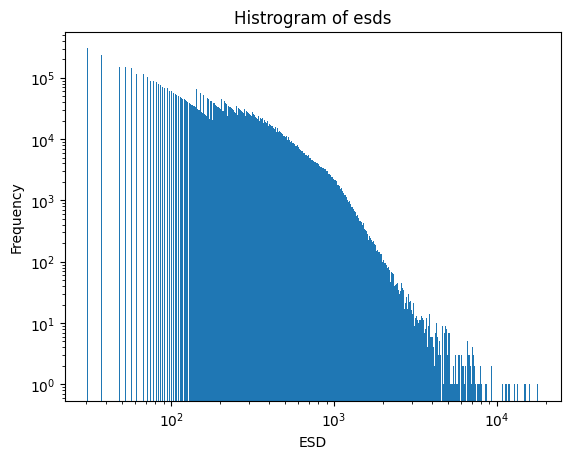

In [8]:
df = crop_df
log_bins = np.logspace(np.log10(df["esd"].min()), np.log10(df["esd"].max()), num=500)
print(len(df.index))
plt.hist(df["esd"], bins=log_bins, log=True)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("ESD")
plt.ylabel("Frequency")
plt.title("Histrogram of esds")
plt.show()

In [ ]:
print('The scikit-learn version is {}.'.format(sklearn.__version__))

In [9]:
def add_ctd_data(ctd_data_loc:str, crop_df):
    #crop_df.drop('depth [m]',axis=1)
    # Reading the specified header line (line 124) to extract column names
    with open(ctd_data_loc, 'r') as file:
        for _ in range(123):
            next(file)  # Skip lines until the header
        header_line = next(file).strip()  # Read the header line

    # Processing the header line to get column names
    # The header line is expected to be in the format "Columns  = column1:column2:..."
    column_names = header_line.split(' = ')[1].split(':')
    ctd_df = pd.read_csv(ctd_data_loc, delim_whitespace=True, header=None, skiprows=124, names=column_names)
    ctd_df['z_factor']=ctd_df['z']/ctd_df['p']
    
    # Function to interpolate a column based on closest pressure values
    def interpolate_column(pressure, column):
        # Sort 'p' values based on the distance from the current pressure
        closest_ps = ctd_df['p'].iloc[(ctd_df['p'] - pressure).abs().argsort()[:2]]
        
        # Get corresponding column values
        column_values = ctd_df.loc[closest_ps.index, column]
        
        # Linear interpolation
        return np.interp(pressure, closest_ps, column_values)
    
    # Columns to interpolate
    columns = ['s', 'o', 't', 'chl', 'z_factor']

    # Identify unique pressures and calculate their interpolated 's' values
    unique_pressures = df['pressure [dbar]'].unique()

    # Interpolate for each column and store the results in a dictionary
    interpolated_columns = {column: {pressure: interpolate_column(pressure, column) 
                                    for pressure in unique_pressures}
                            for column in columns}

    for column in columns:
        new_col_name = f'interpolated_{column}'
        crop_df[new_col_name] = crop_df['pressure [dbar]'].map(interpolated_columns[column])
    # Determine the position of pressure column
    position = crop_df.columns.get_loc('pressure [dbar]') + 1

    # Insert a new column. For example, let's insert a column named 'new_column' with a constant value
    crop_df.insert(position, 'depth [m]', (crop_df['pressure [dbar]']*crop_df['interpolated_z_factor']).round(3))

    return crop_df

In [10]:
ctd_data_loc = '/media/plankton/30781fe1-cea5-4503-ae00-1986beb935d2/Segmentation_results/M181/CTD_preliminary_calibrated/met_181_1_004.ctd'
crop_df = add_ctd_data(ctd_data_loc, crop_df)

In [67]:
crop_df.head()

,date-time,pressure [dbar],depth [m],temperature,index,img_id,area,x,y,w,h,esd,interpolated_s,interpolated_o,interpolated_t,interpolated_chl,interpolated_z_factor
0,20220422-13421311,-0.32,-0.318,27.14,0,1,194.0,904.0,2556.5,62.0,7.0,424.35,35.9972,218.67,24.5219,0.958,0.993333
1,20220422-13421311,-0.32,-0.318,27.14,3209,1,1.5,2241.5,915.0,3.0,2.0,37.31,35.9972,218.67,24.5219,0.958,0.993333
2,20220422-13421311,-0.32,-0.318,27.14,3208,1,8.0,386.5,919.0,5.0,8.0,86.17,35.9972,218.67,24.5219,0.958,0.993333
3,20220422-13421311,-0.32,-0.318,27.14,3207,1,3.0,500.5,917.0,3.0,4.0,52.77,35.9972,218.67,24.5219,0.958,0.993333
4,20220422-13421311,-0.32,-0.318,27.14,3206,1,11.5,1816.0,918.5,8.0,7.0,103.32,35.9972,218.67,24.5219,0.958,0.993333


In [33]:
# Find the index of the minimum value in 'pressure [dbar]' column
min_pressure_index = crop_df['esd'].idxmax()

# Retrieve the row corresponding to this index
min_pressure_row = crop_df.loc[min_pressure_index]

# Print the row
print(min_pressure_row)

date-time                20220422-13534465
pressure [dbar]                     367.04
depth [m]                           364.59
temperature                          11.69
index                                  119
img_id                                2767
area                              346482.5
x                                   1832.0
y                                   1984.0
w                                    468.0
h                                    912.0
esd                               17933.27
interpolated_s                   34.884596
interpolated_o                     27.7676
interpolated_t                    9.556628
interpolated_chl                   0.45228
interpolated_z_factor             0.993324
Name: 5720059, dtype: object


In [24]:
df = crop_df
# Define depth bins with an interval of 5 m
max_depth = df['depth [m]'].max()
min_depth = df['depth [m]'].min()
depth_bins = np.arange(min_depth, max_depth + 5, 5)

# Assign each 'esd' and 'depth [m]' value to its respective bin
df['esd_bin'] = np.digitize(df['esd'], esd_bins, right=False)
df['depth_bin'] = np.digitize(df['depth [m]'], depth_bins)

# Group by the depth bin and count unique values in 'depth [m]'
depth_bin_volumes = df.groupby('depth_bin')['img_id'].nunique()*VOLUME_PER_IMAGE_LITERS

# Group by 'esd_bin' and 'depth_bin' and count occurrences
histogram = df.groupby(['esd_bin', 'depth_bin']).size().reset_index(name='count')
histogram['normalized_count'] = histogram.apply(lambda row: row['count'] / depth_bin_volumes.get(row['depth_bin'], 1), axis=1)

histogram2 = df.groupby(['img_id','esd_bin','depth [m]' ]).size().reset_index(name='count')
histogram2['normalized_count'] = histogram2.apply(lambda row: row['count'] / VOLUME_PER_IMAGE_LITERS, axis=1)
# Pivot the dataframe to make 'esd_bin' values as column headers
pivoted_df = histogram2.pivot(index='img_id', columns='esd_bin', values='normalized_count').reset_index()
pivoted_df1 = histogram.pivot(index='depth_bin', columns='esd_bin', values='normalized_count').reset_index()

# Rename columns for clarity
#pivoted_df.columns = ['depth [m]', 'ESD<125um', 'ESD 125-250um', 'ESD 250-500um', 'ESD 500-1000um', 'ESD >1000um']
#pivoted_df1.columns = ['depth_bin', 'ESD<125um', 'ESD 125-250um', 'ESD 250-500um', 'ESD 500-1000um', 'ESD >1000um']

# Display the pivoted DataFrame
print(histogram2)
# Display the histogram
#print(histogram2)

       img_id  esd_bin  depth [m]  count  normalized_count
0           1        1     -0.318   3183       1654.172029
1           1        2     -0.318   1115        579.453915
2           1        3     -0.318    326        169.418813
3           1        4     -0.318    112         58.205236
4           1        5     -0.318     71         36.897962
...       ...      ...        ...    ...               ...
18129    3805        1    406.084   4398       2285.594905
18130    3805        2    406.084    890        462.523753
18131    3805        3    406.084    227        117.969541
18132    3805        4    406.084     51         26.504170
18133    3805        5    406.084      2          1.039379

[18134 rows x 5 columns]


In [31]:
pivoted_df1

esd_bin,depth_bin,1,2,3,4,5
0,1,865.394110,540.005037,321.776596,99.736041,15.064661
1,2,932.267874,575.210705,344.117451,106.948252,15.499466
2,3,1052.749208,633.086112,365.698939,113.161840,16.035973
3,4,1076.578452,666.938765,404.405132,113.958893,16.675258
4,5,760.312355,468.324264,274.728586,93.066403,21.675253
...,...,...,...,...,...,...
92,93,112.716964,90.082626,56.228560,7.136452,0.222724
93,94,115.907281,92.331521,52.826861,7.630363,0.371207
94,95,123.771322,95.443979,58.971991,7.267135,0.357819
95,96,111.726243,90.025691,54.988779,8.286942,0.358164


In [70]:
histogram2['img_id'].nunique()#*VOLUME_PER_IMAGE_LITERS

3805

In [51]:
# Find the index of the minimum value in 'pressure [dbar]' column
index = histogram2['count'].idxmax()

# Retrieve the row corresponding to this index
row = histogram2.loc[index]

# Print the row
print(row)

img_id               1128.000000
esd_bin                 0.000000
count               12167.000000
normalized_count     6323.063486
Name: 5635, dtype: float64


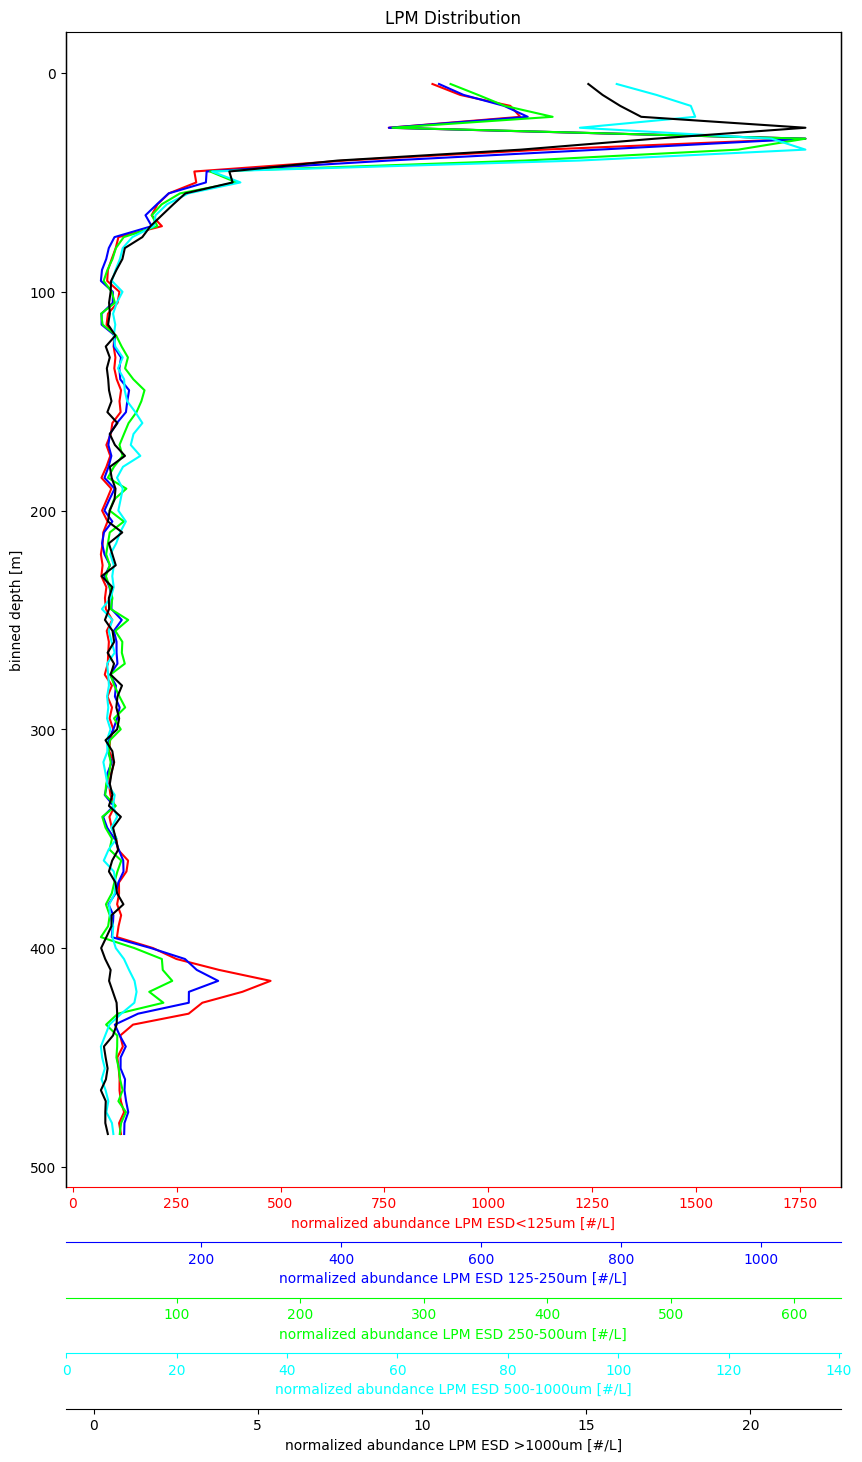

In [20]:
grouped = pivoted_df1
# Plot the data
#plt.figure(figsize=(10, 15))

fig, ax1 = plt.subplots(figsize=(10, 15))


# Assuming the grouped data is sorted by pressure in ascending order
# Inverting the Y-axis to have pressure increase downward

# Plot each LPM size distribution line
ax1.plot(grouped[1], grouped['depth_bin']*5, color='red', label='LPM <125um')
ax1.set_xlabel('normalized abundance LPM ESD<125um [#/L]',color='red')
ax1.invert_yaxis()
ax1.spines['bottom'].set_color('red')
ax1.tick_params(axis='x', colors='red')

ax2 =ax1.twiny()
ax2.set_xlabel('normalized abundance LPM ESD 125-250um [#/L]',color='blue')
ax2.spines['top'].set_visible(False)
ax2.spines['bottom'].set_position(('outward', 40))
ax2.spines['bottom'].set_color('blue')
ax2.xaxis.set_label_position('bottom')
ax2.xaxis.tick_bottom()
ax2.tick_params(axis='x', colors='blue')
ax2.plot(grouped[2], grouped['depth_bin']*5, color='blue', label='LPM 125-250um')

ax3 =ax1.twiny()
ax3.spines['top'].set_visible(False)
ax3.spines['bottom'].set_position(('outward', 80))
ax3.spines['bottom'].set_color('lime')
ax3.xaxis.set_label_position('bottom')
ax3.xaxis.tick_bottom()
ax3.set_xlabel('normalized abundance LPM ESD 250-500um [#/L]',color='lime')
ax3.tick_params(axis='x', colors='lime')
ax3.plot(grouped[3], grouped['depth_bin']*5, color='lime', label='LPM 250-500um')

ax4 =ax1.twiny()
ax4.spines['top'].set_visible(False)
ax4.spines['bottom'].set_position(('outward', 120))
ax4.spines['bottom'].set_color('cyan')
ax4.xaxis.set_label_position('bottom')
ax4.xaxis.tick_bottom()
ax4.set_xlabel('normalized abundance LPM ESD 500-1000um [#/L]',color='cyan')
ax4.tick_params(axis='x', colors='cyan')
ax4.plot(grouped[4], grouped['depth_bin']*5, color='cyan', label='LPM 500-1000um')
# 
ax5 =ax1.twiny()
ax5.spines['top'].set_visible(False)
ax5.spines['bottom'].set_position(('outward', 160))
ax5.spines['bottom'].set_color('black')
ax5.xaxis.set_label_position('bottom')
ax5.xaxis.tick_bottom()
ax5.set_xlabel('normalized abundance LPM ESD >1000um [#/L]',color='black')
ax5.tick_params(axis='x', colors='black')
ax5.plot(grouped[5], grouped['depth_bin']*5, color='black', label='LPM 1000-2000um')

# Set the labels and legend
#plt.xlabel('LPM Abundance')
ax1.set_ylabel('binned depth [m]')
ax1.set_title('LPM Distribution')
#ax1.legend(loc='best')

# Show the plot
plt.show()

KeyError: 'depth [m]'

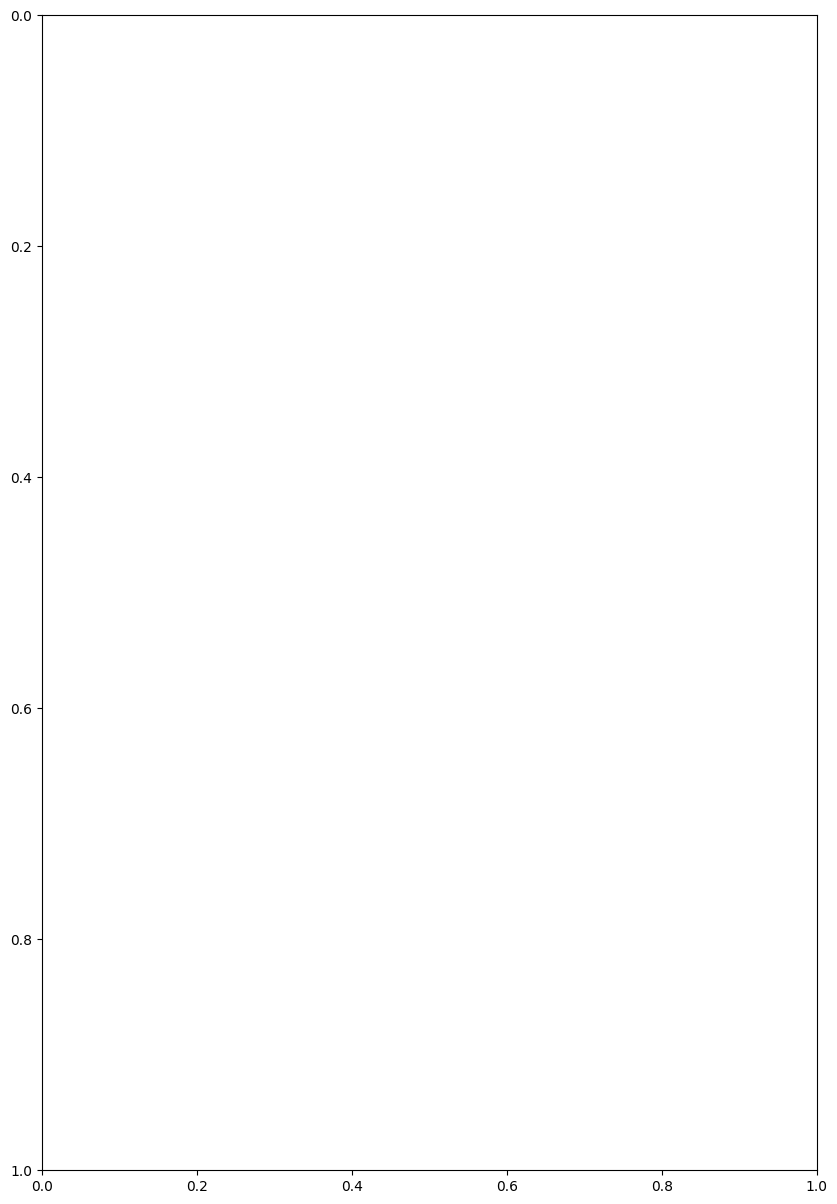

In [57]:
grouped = pivoted_df
# Plot the data
plt.figure(figsize=(10, 15))

# Assuming the grouped data is sorted by pressure in ascending order
# Inverting the Y-axis to have pressure increase downward
plt.gca().invert_yaxis()

# Plot each LPM size distribution line
plt.plot(grouped['ESD<125um'], grouped['depth [m]'], color='black', label='LPM <125um')
plt.plot(grouped['ESD 125-250um'], grouped['depth [m]'], color='red', label='LPM 125-250um')
plt.plot(grouped['ESD 250-500um'], grouped['depth [m]'], color='green', label='LPM 250-500um')
plt.plot(grouped['ESD 500-1000um'], grouped['depth [m]'], color='blue', label='LPM 500-1000um')
plt.plot(grouped['ESD >1000um'], grouped['depth [m]'], color='cyan', label='LPM 1000-2000um')

# Set the labels and legend
plt.xlabel('Normalized Abundance #/l')
plt.ylabel('Image in stream')
plt.title('LPM Distribution by Pressure')
plt.legend(loc='best')

# Show the plot
plt.show()

In [137]:
# Group by 'esd_bin' and sum the 'normalized_count'
sum_normalized_counts = histogram.groupby('esd_bin')['normalized_count'].sum()

# Display the sum of normalized counts for each esd bin
print(sum_normalized_counts)

esd_bin
0    21804.496282
1    14552.857375
2     9198.433718
3     2025.766641
4      228.241745
Name: normalized_count, dtype: float64


In [138]:
# Pivot the histogram DataFrame for heatmap
heatmap_data = histogram.pivot('esd_bin', 'depth_bin', 'normalized_count')
# Create the complete range of 'esd_bin' and 'depth_bin' values
all_esd_bins = np.arange(0, histogram['esd_bin'].max() + 1)
all_depth_bins = np.arange(1, histogram['depth_bin'].max() + 1)

# Reindex the pivoted DataFrame
heatmap_data = heatmap_data.reindex(index=all_esd_bins, columns=all_depth_bins)

# Fill NaN values with 0 or an appropriate value
heatmap_data = heatmap_data.fillna(0)

# Now heatmap_data has the complete range of 'esd_bin' and 'depth_bin', correctly aligned for plotting
print(heatmap_data)

depth_bin           1            2            3            4            5   \
esd_bin                                                                      
0          1135.397073  1118.688519  2601.625501  1142.829434  1055.261114   
1           708.486609   690.111157  1564.692211   707.981151   650.001780   
2           422.170894   412.843425   903.901223   429.291601   381.304331   
3           130.853686   128.283381   279.725757   120.971748   129.169749   
4            19.764835    18.595560    39.637630    17.701428    30.083756   

depth_bin           6            7           8           9           10  ...  \
esd_bin                                                                  ...   
0          1762.462351  1132.143816  654.238518  292.681937  297.287808  ...   
1          1064.181407   768.867786  468.303715  207.549527  206.519581  ...   
2           609.102208   554.729682  381.756382  127.058067  148.428423  ...   
3           127.778683   133.924013   92.910362   26.

/tmp/ipykernel_416252/966894484.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = histogram.pivot('esd_bin', 'depth_bin', 'normalized_count')


/tmp/ipykernel_416252/2633609188.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = histogram.pivot('esd_bin', 'depth_bin', 'normalized_count')


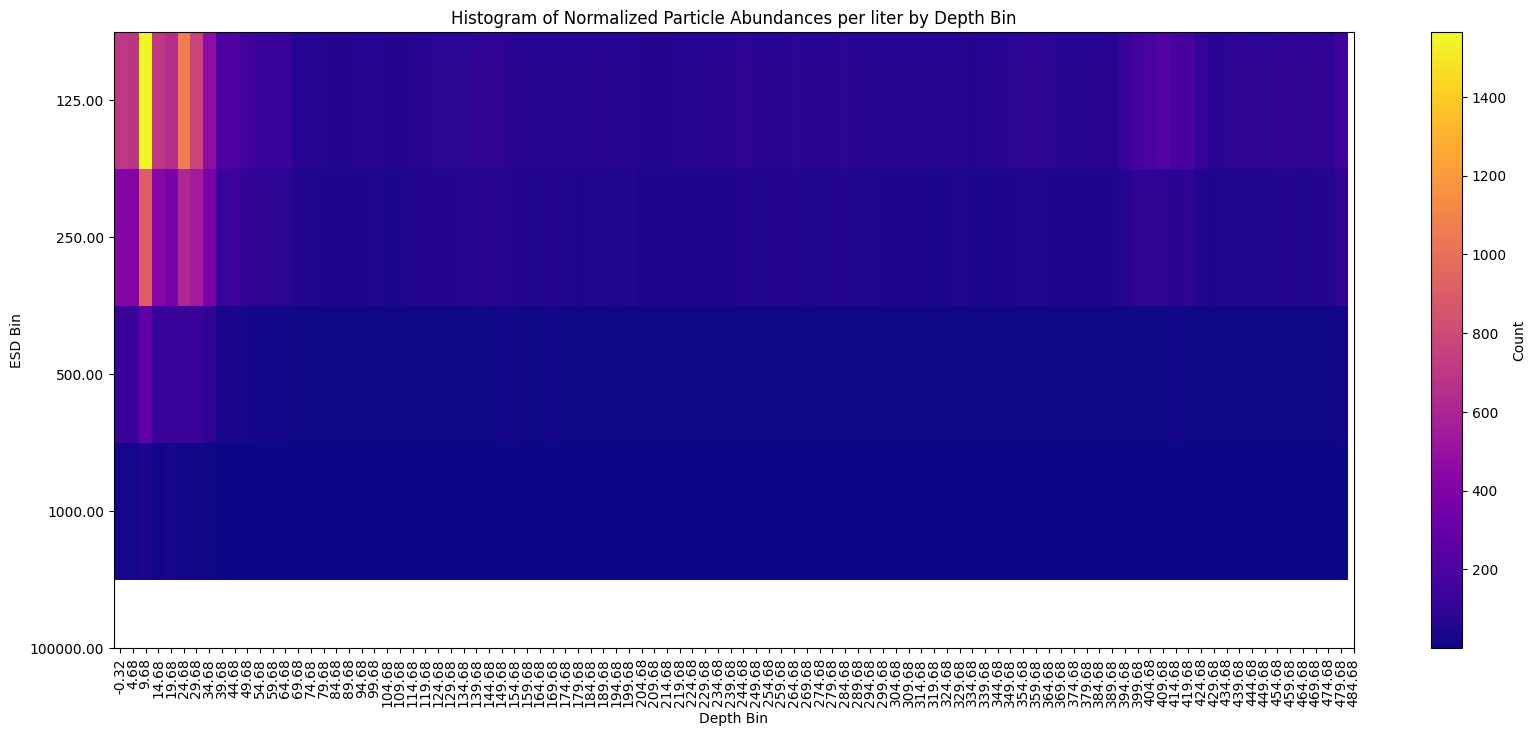

In [139]:
import matplotlib.pyplot as plt

# Pivot the histogram DataFrame for heatmap
heatmap_data = histogram.pivot('esd_bin', 'depth_bin', 'normalized_count')
# Create the complete range of 'esd_bin' and 'depth_bin' values
all_esd_bins = np.arange(1, histogram['esd_bin'].max() + 1)
all_depth_bins = np.arange(1, histogram['depth_bin'].max() + 1)

# Reindex the pivoted DataFrame
heatmap_data = heatmap_data.reindex(index=all_esd_bins, columns=all_depth_bins)

# Fill NaN values with 0 or an appropriate value
#heatmap_data = heatmap_data.fillna(0)

# Now heatmap_data has the complete range of 'esd_bin' and 'depth_bin', correctly aligned for plotting
# Plotting the heatmap
plt.figure(figsize=(20, 8))
plt.imshow(heatmap_data, aspect='auto', cmap='plasma')
plt.colorbar(label='Count')

# Adding labels and title
plt.xlabel('Depth Bin')
plt.ylabel('ESD Bin')
plt.title('Histogram of Normalized Particle Abundances per liter by Depth Bin')

# Adding x and y ticks
plt.xticks(range(len(depth_bins)), [f'{bin:.2f}' for bin in depth_bins], rotation=90)
plt.yticks(range(len(esd_bins)), [f'{bin:.2f}' for bin in esd_bins])

plt.show()


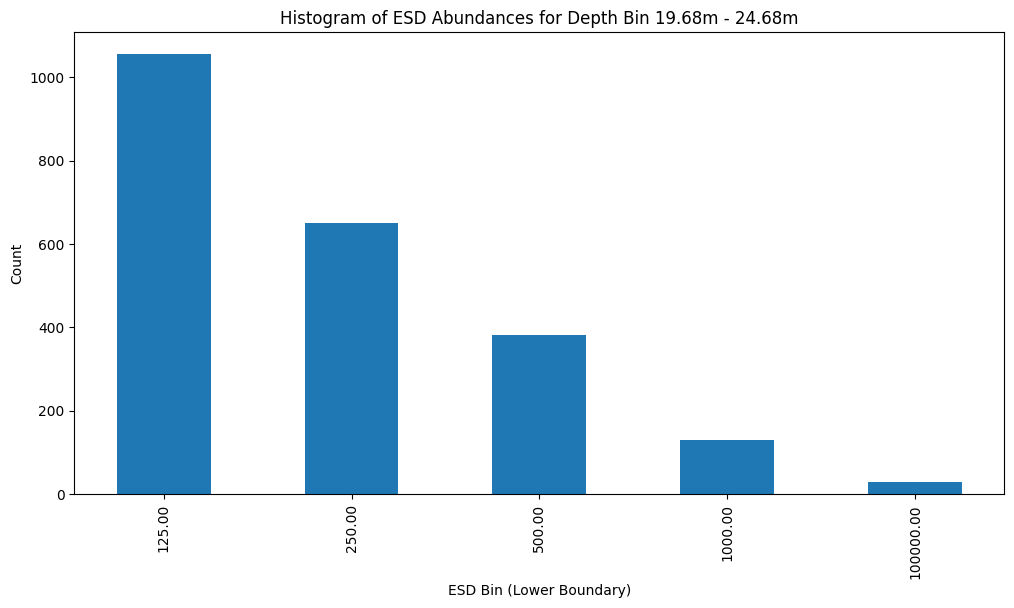

In [140]:
import matplotlib.pyplot as plt

# Assuming 'esd_bins' and 'depth_bins' are defined as in your previous messages

# Select a specific depth bin and its range
selected_depth_bin = 5
depth_bin_range = f"{depth_bins[selected_depth_bin-1]}m - {depth_bins[selected_depth_bin]}m"

# Filter the histogram for the selected depth bin
filtered_histogram = histogram[histogram['depth_bin'] == selected_depth_bin]

# Plotting
plt.figure(figsize=(12, 6))
plt.bar(filtered_histogram['esd_bin'], filtered_histogram['normalized_count'], width=0.5)

# Adding labels and title
plt.xlabel('ESD Bin (Lower Boundary)')
plt.ylabel('Count')
plt.title(f'Histogram of ESD Abundances for Depth Bin {depth_bin_range}')

# Set x-ticks to show esd bin edges (lower boundaries)
plt.xticks(range(len(esd_bins)), [f'{bin:.2f}' for bin in esd_bins], rotation=90)

plt.show()






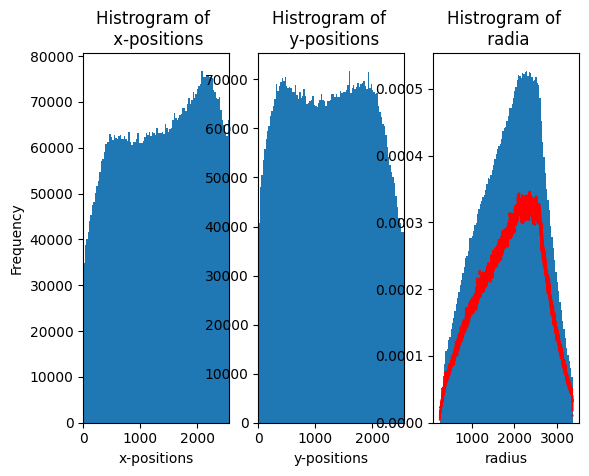

In [141]:
plt.subplot(131)
plt.hist(df["x"], bins=100)
plt.xlim([0, 2560])
plt.xlabel("x-positions")
plt.ylabel("Frequency")
plt.title("Histrogram of \n x-positions")
plt.subplot(132)
plt.hist(df["y"], bins=100)
plt.xlim([0, 2560])
plt.xlabel("y-positions")
plt.title("Histrogram of \n y-positions")
plt.subplot(133)
df["radius"] =  np.sqrt((df["x"] - 2560)**2 + (df["y"] - 2560)**2)
hist, bins = np.histogram(df["radius"], bins=5000)
for i in range(1, len(bins)):
    hist[i-1] /= (bins[i] - bins[i-1]) ** 2 * np.pi
plt.hist(df["radius"], bins=100, density=True)
plt.plot(bins[:-1], hist / np.sum(hist), "r--")
plt.xlabel("radius")
plt.title("Histrogram of \n radia")
plt.show()

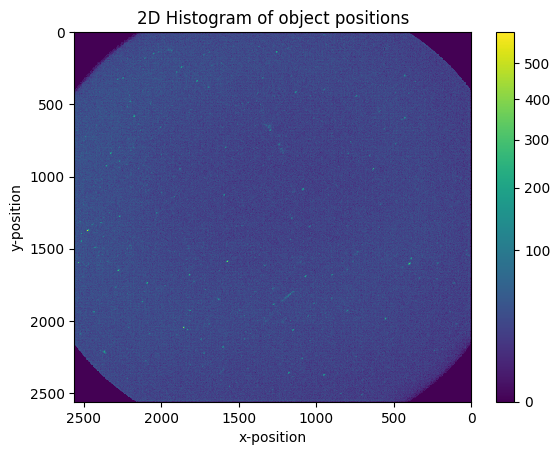

In [142]:
import matplotlib.colors as mcolors
hist2d = plt.hist2d(df["x"], df["y"], bins=np.linspace(0, 2559, 500), norm=mcolors.PowerNorm(0.5))
plt.colorbar()
gca = plt.gca()
gca.invert_xaxis()
gca.invert_yaxis()
plt.xlabel("x-position")
plt.ylabel("y-position")
plt.title("2D Histogram of object positions")
plt.show()

In [24]:
hist, x_bins, y_bins = np.histogram2d(df["x"], df["y"], bins=np.linspace(0, 2559, 500))
print(np.mean(hist[np.where(hist != 0)]), np.max(hist))
# print(x_bins)
# print(y_bins)

26.609562906902067 596.0


In [25]:
def computeHist(x, y, nBins):
    step = 2560 / nBins
    hist = [[0 for j in range(nBins)] for i in range(nBins)]
    hist = np.zeros((nBins, nBins),dtype=np.int64)
    for row in range(len(x)):
        try:
            x_index = int(x[row] // step)
            y_index = int(y[row] // step)
            hist[y_index, x_index] += 1
        except:
            pass
    return hist

In [26]:
hist = computeHist(df["x"], df["y"], 500)

In [27]:
def get_hist_value(x, y):
    step = 2560 / 500
    x_index = int(x // step )
    y_index = int(y // step )
    return hist[x_index][y_index]

In [28]:
df["hist_value"] = df.apply(lambda row: get_hist_value(row["x"], row["y"]), axis=1)
print(df["hist_value"].max())
print(df[df.hist_value > 0].shape[0])

549
6339092


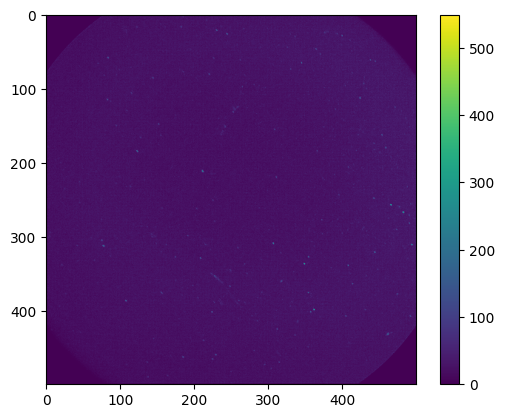

In [29]:
plt.imshow(hist)
# print(len(np.where(hist > 0)[0]) / (1000**2))
plt.colorbar()
plt.show()

26.510413007477293 8.240925496892295
0.210055


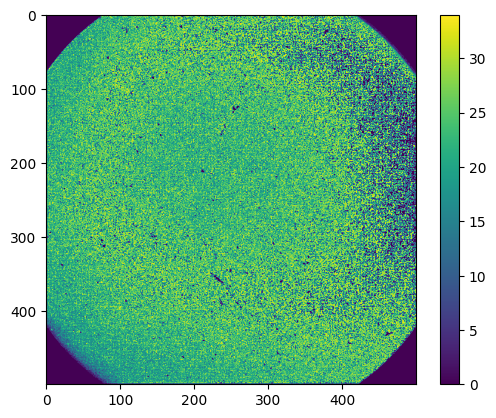

In [30]:
print(np.mean(hist[np.where(hist > 0)]),np.std(hist[np.where(hist > 0)]))
hist[np.where(hist > np.mean(hist[np.where(hist > 0)]) + np.std(hist[np.where(hist > 0)]))] = 0
# hist[np.where(hist > 1)] = 0
print(len(np.where(hist > 0)[0]) / (1000**2))
plt.imshow(hist)
plt.colorbar()
plt.show()

In [31]:
df["hist_value"] = df.apply(lambda row: get_hist_value(row["x"], row["y"]), axis=1)
print(df["hist_value"].max())
print(df[df.hist_value > 0].shape[0])

34
5599547


In [32]:
df['aspect_ratio'] = df[['h', 'w']].min(axis=1) / df[['h', 'w']].max(axis=1)
df.head()

,date-time,pressure [dbar],depth [m],temperature,area,x,y,w,h,esd,interpolated_s,interpolated_o,interpolated_t,interpolated_chl,interpolated_z_factor,esd_bin,depth_bin,radius,hist_value,aspect_ratio
0,20220422-13421311,-0.32,-0.32,27.14,38.0,645.0,477.0,14.0,10.0,187.81,35.9972,218.67,24.5219,0.958,0.993333,3,1,2829.507731,18,0.714286
1,20220422-13421311,-0.32,-0.32,27.14,8.5,1112.5,1338.5,11.0,3.0,88.82,35.9972,218.67,24.5219,0.958,0.993333,0,1,1894.021779,22,0.272727
2,20220422-13421311,-0.32,-0.32,27.14,40.5,1717.0,1341.5,10.0,7.0,193.89,35.9972,218.67,24.5219,0.958,0.993333,3,1,1481.685274,16,0.700000
3,20220422-13421311,-0.32,-0.32,27.14,11.5,2311.5,1340.0,9.0,4.0,103.32,35.9972,218.67,24.5219,0.958,0.993333,1,1,1245.051103,17,0.444444
4,20220422-13421311,-0.32,-0.32,27.14,1.0,39.5,1340.5,3.0,3.0,30.47,35.9972,218.67,24.5219,0.958,0.993333,0,1,2800.017946,29,1.000000


In [ ]:
plot_bins = <125, 125-250, 250-500,500-1000,>1000 

In [ ]:
x = int(4693 // 5.12)
y = int(4263 // 5.12)
print(x, y, hist[x, y])

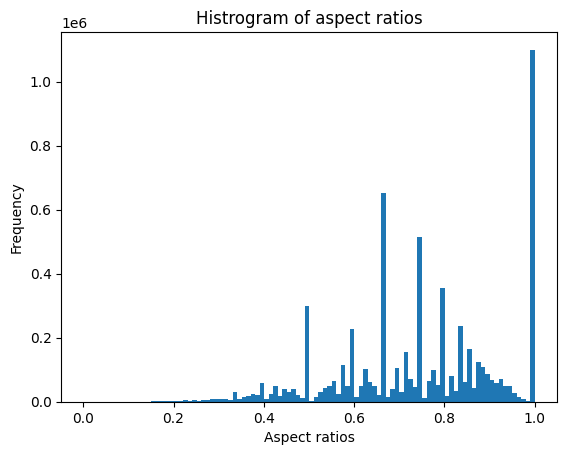

In [34]:
plt.hist(df["aspect_ratio"], bins=100)
plt.xlabel("Aspect ratios")
plt.ylabel("Frequency")
plt.title("Histrogram of aspect ratios")
plt.show()

In [179]:
import re

file_path = '/media/plankton/30781fe1-cea5-4503-ae00-1986beb935d2/Segmentation_results/M181/Templog/20220422_13h_28m__Templog.txt'  # Replace with the path to your log file

# Function to reformat timestamp
def reformat_timestamp(timestamp):
    # Format: YYYYMMDD_HHh_MMm_SSs to YYYYMMDD-HHMMSS
    formatted_timestamp = re.sub(r'(\d{4})(\d{2})(\d{2})_(\d{2})h_(\d{2})m_(\d{2})s', r'\1\2\3-\4\5\6', timestamp)
    return formatted_timestamp

# Read the file line by line
with open(file_path, 'r') as file:
    lines = file.readlines()

# Process the log file
data = [{'timestamp': reformat_timestamp(lines[1].strip())}]
restart = False
for i in range(0, len(lines), 2):
    message = lines[i].strip().lstrip("b'").rstrip("'")
    timestamp = reformat_timestamp(lines[i + 1].strip())

    if data[-1]['timestamp'] == timestamp:

        # Check for sensor readings
        if message.startswith("TT"):
            sensor_data = message.split('_')
            for j in range(1, len(sensor_data), 2):
                sensor_name = sensor_data[j-1]
                sensor_value = float(sensor_data[j])
                data[-1][sensor_name] = sensor_value

        # Update heat and cool states
        if "Restart Tag" in message:
            data[-1]['Restart'] = True
        # else:
        #     data[-1]['Restart'] = False
        #     data[-1]['Heat'] = True
        #     data[-1]['Cool'] = True
        
    else:
        # Initialize a dictionary for the new row data
        row = {'timestamp': timestamp, 'Restart': restart}
        # Check for sensor readings
        if message.startswith("TT"):
            sensor_data = message.split('_')
            for j in range(1, len(sensor_data), 2):
                sensor_name = sensor_data[j-1]
                sensor_value = float(sensor_data[j])
                row[sensor_name] = sensor_value

        # Update heat and cool states
        if "Restart Tag" in message:
            restart = True
        # else:
        #     restart = False
        #     heat_on = True
        #     cool_on = True
        data.append(row)

# Reset the restart flag for subsequent rows
# for i in range(1, len(data)):
#     data[i]['Restart'] = False

# Create DataFrame
log_df = pd.DataFrame(data)

# Display the first few rows of the DataFrame
print(log_df[log_df['Restart'] == True])

# # Group by timestamp and take the first non-null value in each group
# shrinked_df = log_df.groupby('timestamp').first().reset_index()

# shrinked_df.head()


            timestamp     TT     T1     T2     TH Restart
1412  20220422-141005  20.34  19.81  20.88  19.94    True


In [174]:
data[-1]['test']=0.211 
print(data[-1])

{'timestamp': '20220422-142149', 'Heat': False, 'Cool': False, 'Restart': False, 'TT': 20.72, 'T1': 20.5, 'T2': 20.94, 'TH': 20.81, 'test': 0.211}
